In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

Device: cuda


In [3]:
# 데이터 로드 및 전처리
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# 이미지 정규화 및 채널 차원 추가
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
x_train = np.expand_dims(x_train, -1)  # (60000, 28, 28, 1)
x_test = np.expand_dims(x_test, -1)    # (10000, 28, 28, 1)

# 레이블 원-핫 인코딩
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

# 데이터 증강 설정
train_datagen = ImageDataGenerator(
    validation_split=0.2,  # 20% 검증 분할
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1
)

val_datagen = ImageDataGenerator(validation_split=0.2)  # 검증용 제너레이터

# 제너레이터 생성
train_generator = train_datagen.flow(
    x_train, y_train,  # x_train_full -> x_train
    batch_size=128,
    subset='training'
)

val_generator = val_datagen.flow(
    x_train, y_train,  # x_train_full -> x_train
    batch_size=128,
    subset='validation'
)

# CNN 모델 구성
model = keras.Sequential([
    keras.Input(shape=(28,28,1)),
    layers.Conv2D(64, (3,3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(64, (3,3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3,3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(128, (3,3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(256),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

# 모델 컴파일
model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# 콜백 설정
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)

# 모델 학습
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stop, reduce_lr]
)

# 테스트 평가
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

Epoch 1/50


C:\Users\kj2cm\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


375/375 ━━━━━━━━━━━━━━━━━━━━ 132s 338ms/step - accuracy: 0.8304 - loss: 0.5326 - val_accuracy: 0.0939 - val_loss: 11.2515 - learning_rate: 0.0010
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 127s 339ms/step - accuracy: 0.9724 - loss: 0.0931 - val_accuracy: 0.9747 - val_loss: 0.0795 - learning_rate: 0.0010
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 133s 354ms/step - accuracy: 0.9782 - loss: 0.0714 - val_accuracy: 0.9883 - val_loss: 0.0354 - learning_rate: 0.0010
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 130s 346ms/step - accuracy: 0.9818 - loss: 0.0560 - val_accuracy: 0.9809 - val_loss: 0.0653 - learning_rate: 0.0010
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 127s 338ms/step - accuracy: 0.9848 - loss: 0.0517 - val_accuracy: 0.9891 - val_loss: 0.0354 - learning_rate: 0.0010
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 129s 345ms/step - accuracy: 0.9867 - loss: 0.0463 - val_accuracy: 0.9931 - val_loss: 0.0228 - learning_rate: 0.0010
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 134s 358ms/step - accuracy: 0.9866

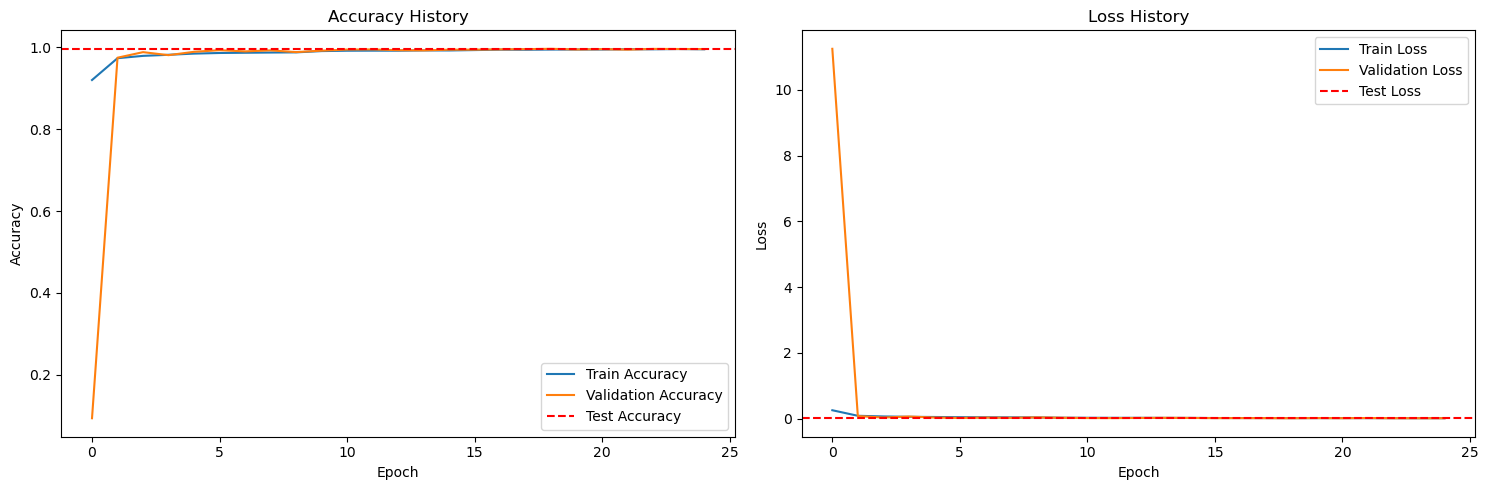

In [4]:
# 학습 결과 시각화
plt.figure(figsize=(15, 5))

# 정확도 그래프
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=test_acc, color='r', linestyle='--', label='Test Accuracy')
plt.title('Accuracy History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
plt.title('Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()